In [1]:
import argparse
from pprint import pprint
import random
from copy import deepcopy

import torch
import torch.backends
from torch import optim
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision.models import vgg16,AlexNet,resnet18,squeezenet1_0
from torchvision.transforms import transforms
from tqdm import tqdm

from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop
from baal.bayesian.dropout import patch_module
from baal import ModelWrapper

import numpy as np
import matplotlib.pyplot as plt
from model import resnet18
import torch.nn as nn
from baal.utils.plot_utils import make_animation_from_data
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import imageio
from IPython.display import HTML
from matplotlib import animation
import os
from IPython.display import display


In [2]:

def parse_args():
    args = {
        "epoch": 53,
        "batch_size": 32,
        "initial_pool": 10,
        "query_size": 10,
        "lr": 0.0001,
        "heuristic": ['bald'],
        "iterations": 20,
        "shuffle_prop": 0.01,
        "learning_epoch": 10,
        "model": ['AlexNet']
    }
    return args



def get_datasets(initial_pool):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    test_transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path
    image_path = os.path.join(data_root, "/root/data/ACRIMA", "")  # flower data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_ds = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                    transform=transform)
    test_set = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                    transform=test_transform)

    active_set = ActiveLearningDataset(train_ds, pool_specifics={"transform": test_transform})

    # We start labeling randomly.
    active_set.label_randomly(initial_pool)   #随机标记数据
    return active_set, test_set



In [3]:
print(torch.cuda.is_available())
args = parse_args()
use_cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
random.seed(1337)
torch.manual_seed(1337)   #1337只是一个标志，每次运行时下面生成的随机数都是同一个

if not use_cuda:
    print("warning, the experiments would take ages to run on cpu")

hyperparams = parse_args()   #返回字典对象
print(hyperparams["heuristic"])

True
['bald']


Start active learning Training: model is  AlexNet 

Start active learning Training: query_strategy is  bald 

reduction on main is  none


  0%|          | 0/53 [00:00<?, ?it/s]

[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:18:24.938944Z [info     ] Starting training              dataset=10 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:18:28.911777Z [info     ] Training complete              train_acc=0.699999988079071 train_loss=0.6434779167175293
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:18:28.914269Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:18:30.129898Z [info     ] Evaluation complete            test_acc=0.5208333134651184 test_loss=0.6686129570007324
Uth----------- tensor(0.7912)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:18:30.136337Z [info     ] Start Predict                  dataset=520

100%|██████████| 52/52 [00:02<00:00, 20.85it/s]
!!!Save weights in AlexNetal
Uncertain_th update to 0.7911645


  2%|▏         | 1/53 [00:08<07:44,  8.94s/it]

{'dataset_size': 10,
 'test_accuracy': 0.5208333134651184,
 'test_loss': 0.6686129570007324,
 'train_accuracy': 0.699999988079071,
 'train_loss': 0.6434779167175293}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:18:33.879490Z [info     ] Starting training              dataset=20 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:18:38.605328Z [info     ] Training complete              train_acc=0.699999988079071 train_loss=0.5960108637809753
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:18:38.608789Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:18:39.666505Z [info     ] Evaluation complete            test_acc=0.5 test_loss=0.7076972126960754
Uth----------- tensor(0.7869)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:18:39.675936Z [info     ] Start Predict                  dataset

  4%|▍         | 2/53 [00:17<07:15,  8.53s/it]


{'dataset_size': 20,
 'test_accuracy': 0.5,
 'test_loss': 0.7076972126960754,
 'train_accuracy': 0.699999988079071,
 'train_loss': 0.5960108637809753}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:18:42.124395Z [info     ] Starting training              dataset=30 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:18:47.568717Z [info     ] Training complete              train_acc=0.6000000238418579 train_loss=0.5989528298377991
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:18:47.574958Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:18:48.776236Z [info     ] Evaluation complete            test_acc=0.5645833611488342 test_loss=0.6353631615638733
Uth----------- tensor(0.8709)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:18:48.782841Z [info     ] Start Predict                  datas

  6%|▌         | 3/53 [00:27<07:42,  9.25s/it]

{'dataset_size': 30,
 'test_accuracy': 0.5645833611488342,
 'test_loss': 0.6353631615638733,
 'train_accuracy': 0.6000000238418579,
 'train_loss': 0.5989528298377991}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:18:52.241572Z [info     ] Starting training              dataset=40 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:18:58.431811Z [info     ] Training complete              train_acc=0.921875 train_loss=0.4276672601699829
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:18:58.434138Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:18:59.516590Z [info     ] Evaluation complete            test_acc=0.7711805701255798 test_loss=0.5693051815032959
Uth----------- tensor(0.8953)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:18:59.523367Z [info     ] Start Predict                  

  8%|▊         | 4/53 [00:38<08:02,  9.85s/it]

{'dataset_size': 40,
 'test_accuracy': 0.7711805701255798,
 'test_loss': 0.5693051815032959,
 'train_accuracy': 0.921875,
 'train_loss': 0.4276672601699829}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:19:03.004193Z [info     ] Starting training              dataset=50 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:19:09.094076Z [info     ] Training complete              train_acc=0.9166666269302368 train_loss=0.4845643639564514
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:19:09.098254Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:19:10.200973Z [info     ] Evaluation complete            test_acc=0.7756944298744202 test_loss=0.5490373969078064
Uth----------- tensor(0.8676)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:19:10.207603Z [info     ] Start Predict                  

  9%|▉         | 5/53 [00:48<08:05, 10.12s/it]

{'dataset_size': 50,
 'test_accuracy': 0.7756944298744202,
 'test_loss': 0.5490373969078064,
 'train_accuracy': 0.9166666269302368,
 'train_loss': 0.4845643639564514}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:19:13.594034Z [info     ] Starting training              dataset=60 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:19:19.916724Z [info     ] Training complete              train_acc=0.8995535969734192 train_loss=0.4393761456012726
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:19:19.921287Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:19:21.098014Z [info     ] Evaluation complete            test_acc=0.9302083849906921 test_loss=0.500485360622406
Uth----------- tensor(0.8466)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:19:21.104677Z [info     ] Start Predict         

 11%|█▏        | 6/53 [00:59<08:07, 10.37s/it]

{'dataset_size': 60,
 'test_accuracy': 0.9302083849906921,
 'test_loss': 0.500485360622406,
 'train_accuracy': 0.8995535969734192,
 'train_loss': 0.4393761456012726}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:19:24.456347Z [info     ] Starting training              dataset=70 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:19:31.217987Z [info     ] Training complete              train_acc=0.7048611640930176 train_loss=0.4437674582004547
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:19:31.221116Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:19:32.388918Z [info     ] Evaluation complete            test_acc=0.7260416150093079 test_loss=0.49681583046913147
Uth----------- tensor(0.6682)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:19:32.395753Z [info     ] Start Predict        

 13%|█▎        | 7/53 [01:09<07:55, 10.33s/it]


{'dataset_size': 70,
 'test_accuracy': 0.7260416150093079,
 'test_loss': 0.49681583046913147,
 'train_accuracy': 0.7048611640930176,
 'train_loss': 0.4437674582004547}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:19:34.694959Z [info     ] Starting training              dataset=80 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:19:41.950546Z [info     ] Training complete              train_acc=0.90625 train_loss=0.3638102114200592
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:19:41.954374Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:19:43.048128Z [info     ] Evaluation complete            test_acc=0.8968749642372131 test_loss=0.40226879715919495
Uth----------- tensor(0.7096)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:19:43.054793Z [info     ] Start Predict                

 15%|█▌        | 8/53 [01:20<07:49, 10.43s/it]


{'dataset_size': 80,
 'test_accuracy': 0.8968749642372131,
 'test_loss': 0.40226879715919495,
 'train_accuracy': 0.90625,
 'train_loss': 0.3638102114200592}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:19:45.339820Z [info     ] Starting training              dataset=90 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:19:52.053317Z [info     ] Training complete              train_acc=0.7852563858032227 train_loss=0.4434284269809723
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:19:52.057646Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:19:53.186157Z [info     ] Evaluation complete            test_acc=0.8857638835906982 test_loss=0.4304652214050293
Uth----------- tensor(0.6871)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:19:53.193400Z [info     ] Start Predict                 

 17%|█▋        | 9/53 [01:30<07:33, 10.31s/it]


{'dataset_size': 90,
 'test_accuracy': 0.8857638835906982,
 'test_loss': 0.4304652214050293,
 'train_accuracy': 0.7852563858032227,
 'train_loss': 0.4434284269809723}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:19:55.393145Z [info     ] Starting training              dataset=100 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:20:02.021820Z [info     ] Training complete              train_acc=0.8046875 train_loss=0.43004608154296875
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:20:02.023991Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:20:03.144940Z [info     ] Evaluation complete            test_acc=0.8968749642372131 test_loss=0.38742342591285706
Uth----------- tensor(0.6665)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:20:03.151534Z [info     ] Start Predict             

 19%|█▉        | 10/53 [01:40<07:18, 10.20s/it]


{'dataset_size': 100,
 'test_accuracy': 0.8968749642372131,
 'test_loss': 0.38742342591285706,
 'train_accuracy': 0.8046875,
 'train_loss': 0.43004608154296875}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:20:05.353829Z [info     ] Starting training              dataset=110 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:20:12.143233Z [info     ] Training complete              train_acc=0.8939732313156128 train_loss=0.32759782671928406
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:20:12.146097Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:20:13.232664Z [info     ] Evaluation complete            test_acc=0.9079861640930176 test_loss=0.35963085293769836
Uth----------- tensor(0.6978)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:20:13.239439Z [info     ] Start Predict          

 21%|██        | 11/53 [01:50<07:06, 10.14s/it]


{'dataset_size': 110,
 'test_accuracy': 0.9079861640930176,
 'test_loss': 0.35963085293769836,
 'train_accuracy': 0.8939732313156128,
 'train_loss': 0.32759782671928406}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:20:15.365376Z [info     ] Starting training              dataset=120 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:20:22.232731Z [info     ] Training complete              train_acc=0.8333333730697632 train_loss=0.41869476437568665
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:20:22.236686Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:20:23.297680Z [info     ] Evaluation complete            test_acc=0.925694465637207 test_loss=0.35379138588905334
Uth----------- tensor(0.6615)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:20:23.304991Z [info     ] Start Predict  

 23%|██▎       | 12/53 [02:00<06:54, 10.11s/it]


{'dataset_size': 120,
 'test_accuracy': 0.925694465637207,
 'test_loss': 0.35379138588905334,
 'train_accuracy': 0.8333333730697632,
 'train_loss': 0.41869476437568665}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:20:25.392671Z [info     ] Starting training              dataset=130 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:20:32.423217Z [info     ] Training complete              train_acc=0.893750011920929 train_loss=0.38077443838119507
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:20:32.425061Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:20:33.507563Z [info     ] Evaluation complete            test_acc=0.893750011920929 test_loss=0.3633088171482086
Uth----------- tensor(0.6430)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:20:33.513908Z [info     ] Start Predict     

 25%|██▍       | 13/53 [02:10<06:45, 10.13s/it]


{'dataset_size': 130,
 'test_accuracy': 0.893750011920929,
 'test_loss': 0.3633088171482086,
 'train_accuracy': 0.893750011920929,
 'train_loss': 0.38077443838119507}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:20:35.561743Z [info     ] Starting training              dataset=140 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:20:42.631257Z [info     ] Training complete              train_acc=0.8645833730697632 train_loss=0.365802139043808
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:20:42.634044Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:20:43.725436Z [info     ] Evaluation complete            test_acc=0.8736111521720886 test_loss=0.3870314359664917
Uth----------- tensor(0.6847)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:20:43.731925Z [info     ] Start Predict       

 26%|██▋       | 14/53 [02:20<06:35, 10.13s/it]


{'dataset_size': 140,
 'test_accuracy': 0.8736111521720886,
 'test_loss': 0.3870314359664917,
 'train_accuracy': 0.8645833730697632,
 'train_loss': 0.365802139043808}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:20:45.695474Z [info     ] Starting training              dataset=150 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:20:53.317267Z [info     ] Training complete              train_acc=0.8204545974731445 train_loss=0.41453367471694946
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:20:53.322296Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:20:54.459061Z [info     ] Evaluation complete            test_acc=0.9263889193534851 test_loss=0.33798491954803467
Uth----------- tensor(0.6924)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:20:54.466098Z [info     ] Start Predict    

 28%|██▊       | 15/53 [02:31<06:32, 10.33s/it]


{'dataset_size': 150,
 'test_accuracy': 0.9263889193534851,
 'test_loss': 0.33798491954803467,
 'train_accuracy': 0.8204545974731445,
 'train_loss': 0.41453367471694946}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:20:56.490802Z [info     ] Starting training              dataset=160 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:21:05.174679Z [info     ] Training complete              train_acc=0.824999988079071 train_loss=0.40871042013168335
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:21:05.179162Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:21:06.339106Z [info     ] Evaluation complete            test_acc=0.9197916984558105 test_loss=0.34767982363700867
Uth----------- tensor(0.6680)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:21:06.345827Z [info     ] Start Predict  

 30%|███       | 16/53 [02:43<06:38, 10.76s/it]


{'dataset_size': 160,
 'test_accuracy': 0.9197916984558105,
 'test_loss': 0.34767982363700867,
 'train_accuracy': 0.824999988079071,
 'train_loss': 0.40871042013168335}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:21:08.249915Z [info     ] Starting training              dataset=170 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:21:16.873982Z [info     ] Training complete              train_acc=0.8843750357627869 train_loss=0.3609232008457184
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:21:16.876847Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:21:17.953985Z [info     ] Evaluation complete            test_acc=0.9190972447395325 test_loss=0.30009591579437256
Uth----------- tensor(0.5967)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:21:17.960854Z [info     ] Start Predict   

 32%|███▏      | 17/53 [02:54<06:36, 11.01s/it]


{'dataset_size': 170,
 'test_accuracy': 0.9190972447395325,
 'test_loss': 0.30009591579437256,
 'train_accuracy': 0.8843750357627869,
 'train_loss': 0.3609232008457184}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:21:19.843049Z [info     ] Starting training              dataset=180 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:21:28.531878Z [info     ] Training complete              train_acc=0.8541666865348816 train_loss=0.3650049865245819
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:21:28.535418Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:21:29.679644Z [info     ] Evaluation complete            test_acc=0.9302083849906921 test_loss=0.3136574625968933
Uth----------- tensor(0.6111)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:21:29.686840Z [info     ] Start Predict    

 34%|███▍      | 18/53 [03:06<06:32, 11.22s/it]


{'dataset_size': 180,
 'test_accuracy': 0.9302083849906921,
 'test_loss': 0.3136574625968933,
 'train_accuracy': 0.8541666865348816,
 'train_loss': 0.3650049865245819}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:21:31.556674Z [info     ] Starting training              dataset=190 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:21:40.212916Z [info     ] Training complete              train_acc=0.8361110687255859 train_loss=0.3887850344181061
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:21:40.217545Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:21:41.394369Z [info     ] Evaluation complete            test_acc=0.941319465637207 test_loss=0.30741944909095764
Uth----------- tensor(0.6238)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:21:41.400866Z [info     ] Start Predict     

 36%|███▌      | 19/53 [03:19<06:36, 11.68s/it]

{'dataset_size': 190,
 'test_accuracy': 0.941319465637207,
 'test_loss': 0.30741944909095764,
 'train_accuracy': 0.8361110687255859,
 'train_loss': 0.3887850344181061}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:21:44.289282Z [info     ] Starting training              dataset=200 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:21:53.066821Z [info     ] Training complete              train_acc=0.8482142686843872 train_loss=0.3636952042579651
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:21:53.069744Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:21:54.159515Z [info     ] Evaluation complete            test_acc=0.8499999642372131 test_loss=0.38627514243125916
Uth----------- tensor(0.5601)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:21:54.166380Z [info     ] Start Predict     

 38%|███▊      | 20/53 [03:31<06:25, 11.67s/it]


{'dataset_size': 200,
 'test_accuracy': 0.8499999642372131,
 'test_loss': 0.38627514243125916,
 'train_accuracy': 0.8482142686843872,
 'train_loss': 0.3636952042579651}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:21:55.943353Z [info     ] Starting training              dataset=210 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:22:05.188307Z [info     ] Training complete              train_acc=0.85317462682724 train_loss=0.378505140542984
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:22:05.191659Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:22:06.329334Z [info     ] Evaluation complete            test_acc=0.9027778506278992 test_loss=0.30647012591362
Uth----------- tensor(0.5590)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:22:06.335891Z [info     ] Start Predict         

 40%|███▉      | 21/53 [03:43<06:18, 11.82s/it]


{'dataset_size': 210,
 'test_accuracy': 0.9027778506278992,
 'test_loss': 0.30647012591362,
 'train_accuracy': 0.85317462682724,
 'train_loss': 0.378505140542984}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:22:08.106248Z [info     ] Starting training              dataset=220 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:22:17.442560Z [info     ] Training complete              train_acc=0.8131377100944519 train_loss=0.39555230736732483
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:22:17.446891Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:22:18.535960Z [info     ] Evaluation complete            test_acc=0.910069465637207 test_loss=0.30782371759414673
Uth----------- tensor(0.6414)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:22:18.542674Z [info     ] Start Predict         

 42%|████▏     | 22/53 [03:55<06:08, 11.90s/it]


{'dataset_size': 220,
 'test_accuracy': 0.910069465637207,
 'test_loss': 0.30782371759414673,
 'train_accuracy': 0.8131377100944519,
 'train_loss': 0.39555230736732483}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:22:20.200128Z [info     ] Starting training              dataset=230 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:22:29.850760Z [info     ] Training complete              train_acc=0.8541666865348816 train_loss=0.36389440298080444
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:22:29.853000Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:22:30.950648Z [info     ] Evaluation complete            test_acc=0.9152777791023254 test_loss=0.2718903124332428
Uth----------- tensor(0.6062)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:22:30.957060Z [info     ] Start Predict   

 43%|████▎     | 23/53 [04:07<06:01, 12.05s/it]


{'dataset_size': 230,
 'test_accuracy': 0.9152777791023254,
 'test_loss': 0.2718903124332428,
 'train_accuracy': 0.8541666865348816,
 'train_loss': 0.36389440298080444}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:22:32.608906Z [info     ] Starting training              dataset=240 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:22:41.998444Z [info     ] Training complete              train_acc=0.87890625 train_loss=0.32490721344947815
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:22:42.002269Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:22:43.104491Z [info     ] Evaluation complete            test_acc=0.9354166984558105 test_loss=0.2607692778110504
Uth----------- tensor(0.5771)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:22:43.110967Z [info     ] Start Predict           

 45%|████▌     | 24/53 [04:19<05:49, 12.06s/it]


{'dataset_size': 240,
 'test_accuracy': 0.9354166984558105,
 'test_loss': 0.2607692778110504,
 'train_accuracy': 0.87890625,
 'train_loss': 0.32490721344947815}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:22:44.673269Z [info     ] Starting training              dataset=250 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:22:54.153013Z [info     ] Training complete              train_acc=0.8617788553237915 train_loss=0.3371378481388092
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:22:54.157265Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:22:55.290593Z [info     ] Evaluation complete            test_acc=0.9354166984558105 test_loss=0.2530975043773651
Uth----------- tensor(0.5540)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:22:55.297066Z [info     ] Start Predict            

 47%|████▋     | 25/53 [04:31<05:38, 12.09s/it]


{'dataset_size': 250,
 'test_accuracy': 0.9354166984558105,
 'test_loss': 0.2530975043773651,
 'train_accuracy': 0.8617788553237915,
 'train_loss': 0.3371378481388092}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:22:56.829006Z [info     ] Starting training              dataset=260 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:23:06.631191Z [info     ] Training complete              train_acc=0.8368055820465088 train_loss=0.3615581691265106
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:23:06.633436Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:23:07.833011Z [info     ] Evaluation complete            test_acc=0.9465277791023254 test_loss=0.2460666447877884
Uth----------- tensor(0.5706)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:23:07.839828Z [info     ] Start Predict     

 49%|████▉     | 26/53 [04:45<05:39, 12.58s/it]

{'dataset_size': 260,
 'test_accuracy': 0.9465277791023254,
 'test_loss': 0.2460666447877884,
 'train_accuracy': 0.8368055820465088,
 'train_loss': 0.3615581691265106}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:23:10.558854Z [info     ] Starting training              dataset=270 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:23:20.290454Z [info     ] Training complete              train_acc=0.879960298538208 train_loss=0.3115188181400299
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:23:20.293410Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:23:21.383761Z [info     ] Evaluation complete            test_acc=0.956944465637207 test_loss=0.22175247967243195
Uth----------- tensor(0.5460)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:23:21.390327Z [info     ] Start Predict       

 51%|█████     | 27/53 [04:59<05:33, 12.83s/it]

{'dataset_size': 270,
 'test_accuracy': 0.956944465637207,
 'test_loss': 0.22175247967243195,
 'train_accuracy': 0.879960298538208,
 'train_loss': 0.3115188181400299}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:23:23.968746Z [info     ] Starting training              dataset=280 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:23:34.261800Z [info     ] Training complete              train_acc=0.8090277910232544 train_loss=0.40370047092437744
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:23:34.266142Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:23:35.388276Z [info     ] Evaluation complete            test_acc=0.9295139312744141 test_loss=0.24066509306430817
Uth----------- tensor(0.5215)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:23:35.395423Z [info     ] Start Predict     

 53%|█████▎    | 28/53 [05:11<05:21, 12.87s/it]

{'dataset_size': 280,
 'test_accuracy': 0.9295139312744141,
 'test_loss': 0.24066509306430817,
 'train_accuracy': 0.8090277910232544,
 'train_loss': 0.40370047092437744}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:23:36.922084Z [info     ] Starting training              dataset=290 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:23:48.033913Z [info     ] Training complete              train_acc=0.7875000238418579 train_loss=0.41569891571998596
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:23:48.035842Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:23:49.151280Z [info     ] Evaluation complete            test_acc=0.7857639193534851 test_loss=0.4324783384799957
Uth----------- tensor(0.6386)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:23:49.158126Z [info     ] Start Predict   

 55%|█████▍    | 29/53 [05:25<05:14, 13.09s/it]


{'dataset_size': 290,
 'test_accuracy': 0.7857639193534851,
 'test_loss': 0.4324783384799957,
 'train_accuracy': 0.7875000238418579,
 'train_loss': 0.41569891571998596}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:23:50.521905Z [info     ] Starting training              dataset=300 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:24:01.613791Z [info     ] Training complete              train_acc=0.9010416865348816 train_loss=0.26744550466537476
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:24:01.616899Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:24:02.708131Z [info     ] Evaluation complete            test_acc=0.9204861521720886 test_loss=0.22999142110347748
Uth----------- tensor(0.5597)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:24:02.715307Z [info     ] Start Predict  

 57%|█████▋    | 30/53 [05:39<05:04, 13.23s/it]


{'dataset_size': 300,
 'test_accuracy': 0.9204861521720886,
 'test_loss': 0.22999142110347748,
 'train_accuracy': 0.9010416865348816,
 'train_loss': 0.26744550466537476}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:24:04.080013Z [info     ] Starting training              dataset=310 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:24:15.812404Z [info     ] Training complete              train_acc=0.9005681872367859 train_loss=0.25893792510032654
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:24:15.816347Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:24:16.931491Z [info     ] Evaluation complete            test_acc=0.913194477558136 test_loss=0.23995669186115265
Uth----------- tensor(0.5246)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:24:16.938753Z [info     ] Start Predict  

 58%|█████▊    | 31/53 [05:53<04:57, 13.53s/it]

{'dataset_size': 310,
 'test_accuracy': 0.913194477558136,
 'test_loss': 0.23995669186115265,
 'train_accuracy': 0.9005681872367859,
 'train_loss': 0.25893792510032654}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:24:18.324556Z [info     ] Starting training              dataset=320 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:24:29.749695Z [info     ] Training complete              train_acc=0.887499988079071 train_loss=0.2688557803630829
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:24:29.756618Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:24:31.001518Z [info     ] Evaluation complete            test_acc=0.9243056178092957 test_loss=0.23958426713943481
Uth----------- tensor(0.5317)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:24:31.008114Z [info     ] Start Predict     

 60%|██████    | 32/53 [06:07<04:46, 13.67s/it]


{'dataset_size': 320,
 'test_accuracy': 0.9243056178092957,
 'test_loss': 0.23958426713943481,
 'train_accuracy': 0.887499988079071,
 'train_loss': 0.2688557803630829}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:24:32.303106Z [info     ] Starting training              dataset=330 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:24:43.568546Z [info     ] Training complete              train_acc=0.8914772272109985 train_loss=0.26337945461273193
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:24:43.572202Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:24:44.778725Z [info     ] Evaluation complete            test_acc=0.928819477558136 test_loss=0.24450750648975372
Uth----------- tensor(0.5097)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:24:44.785633Z [info     ] Start Predict    

 62%|██████▏   | 33/53 [06:21<04:33, 13.68s/it]


{'dataset_size': 330,
 'test_accuracy': 0.928819477558136,
 'test_loss': 0.24450750648975372,
 'train_accuracy': 0.8914772272109985,
 'train_loss': 0.26337945461273193}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:24:46.018307Z [info     ] Starting training              dataset=340 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:24:57.572146Z [info     ] Training complete              train_acc=0.8999999761581421 train_loss=0.2740989625453949
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:24:57.576551Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:24:58.671959Z [info     ] Evaluation complete            test_acc=0.9138889312744141 test_loss=0.22840161621570587
Uth----------- tensor(0.5386)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:24:58.679679Z [info     ] Start Predict   

 64%|██████▍   | 34/53 [06:34<04:20, 13.72s/it]


{'dataset_size': 340,
 'test_accuracy': 0.9138889312744141,
 'test_loss': 0.22840161621570587,
 'train_accuracy': 0.8999999761581421,
 'train_loss': 0.2740989625453949}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:24:59.828584Z [info     ] Starting training              dataset=350 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:25:11.194778Z [info     ] Training complete              train_acc=0.8945075869560242 train_loss=0.2751240134239197
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:25:11.199483Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:25:12.281936Z [info     ] Evaluation complete            test_acc=0.9309027791023254 test_loss=0.21067680418491364
Uth----------- tensor(0.5407)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:25:12.288845Z [info     ] Start Predict   

 66%|██████▌   | 35/53 [06:48<04:06, 13.67s/it]


{'dataset_size': 350,
 'test_accuracy': 0.9309027791023254,
 'test_loss': 0.21067680418491364,
 'train_accuracy': 0.8945075869560242,
 'train_loss': 0.2751240134239197}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:25:13.392607Z [info     ] Starting training              dataset=360 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:25:25.143936Z [info     ] Training complete              train_acc=0.8932291865348816 train_loss=0.2468014806509018
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:25:25.146395Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:25:26.215510Z [info     ] Evaluation complete            test_acc=0.8996527791023254 test_loss=0.22459734976291656
Uth----------- tensor(0.5419)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:25:26.222010Z [info     ] Start Predict   

 68%|██████▊   | 36/53 [07:02<03:53, 13.73s/it]


{'dataset_size': 360,
 'test_accuracy': 0.8996527791023254,
 'test_loss': 0.22459734976291656,
 'train_accuracy': 0.8932291865348816,
 'train_loss': 0.2468014806509018}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:25:27.269133Z [info     ] Starting training              dataset=370 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:25:39.338218Z [info     ] Training complete              train_acc=0.8929398059844971 train_loss=0.25705257058143616
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:25:39.341585Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:25:40.463828Z [info     ] Evaluation complete            test_acc=0.8951389193534851 test_loss=0.282584011554718
Uth----------- tensor(0.5374)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:25:40.471344Z [info     ] Start Predict    

 70%|██████▉   | 37/53 [07:16<03:42, 13.88s/it]


{'dataset_size': 370,
 'test_accuracy': 0.8951389193534851,
 'test_loss': 0.282584011554718,
 'train_accuracy': 0.8929398059844971,
 'train_loss': 0.25705257058143616}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:25:41.487173Z [info     ] Starting training              dataset=380 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:25:53.134148Z [info     ] Training complete              train_acc=0.8924851417541504 train_loss=0.24403589963912964
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:25:53.138516Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:25:54.210782Z [info     ] Evaluation complete            test_acc=0.9302083849906921 test_loss=0.20767901837825775
Uth----------- tensor(0.5318)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:25:54.217350Z [info     ] Start Predict   

 72%|███████▏  | 38/53 [07:30<03:27, 13.84s/it]


{'dataset_size': 380,
 'test_accuracy': 0.9302083849906921,
 'test_loss': 0.20767901837825775,
 'train_accuracy': 0.8924851417541504,
 'train_loss': 0.24403589963912964}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:25:55.230644Z [info     ] Starting training              dataset=390 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:26:07.011668Z [info     ] Training complete              train_acc=0.9278846383094788 train_loss=0.19323107600212097
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:26:07.013935Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:26:08.132564Z [info     ] Evaluation complete            test_acc=0.941319465637207 test_loss=0.17759239673614502
Uth----------- tensor(0.5139)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:26:08.138980Z [info     ] Start Predict  

 74%|███████▎  | 39/53 [07:44<03:13, 13.83s/it]


{'dataset_size': 390,
 'test_accuracy': 0.941319465637207,
 'test_loss': 0.17759239673614502,
 'train_accuracy': 0.9278846383094788,
 'train_loss': 0.19323107600212097}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:26:09.053538Z [info     ] Starting training              dataset=400 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:26:21.178034Z [info     ] Training complete              train_acc=0.8966346383094788 train_loss=0.24885812401771545
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:26:21.181533Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:26:22.262532Z [info     ] Evaluation complete            test_acc=0.9361111521720886 test_loss=0.18624156713485718
Uth----------- tensor(0.5298)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:26:22.273247Z [info     ] Start Predict  

 75%|███████▌  | 40/53 [07:58<03:00, 13.91s/it]


{'dataset_size': 400,
 'test_accuracy': 0.9361111521720886,
 'test_loss': 0.18624156713485718,
 'train_accuracy': 0.8966346383094788,
 'train_loss': 0.24885812401771545}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:26:23.148635Z [info     ] Starting training              dataset=410 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:26:36.018037Z [info     ] Training complete              train_acc=0.8829511404037476 train_loss=0.2682037651538849
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:26:36.022199Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:26:37.129725Z [info     ] Evaluation complete            test_acc=0.941319465637207 test_loss=0.19361884891986847
Uth----------- tensor(0.5290)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:26:37.137004Z [info     ] Start Predict   

 77%|███████▋  | 41/53 [08:13<02:50, 14.23s/it]


{'dataset_size': 410,
 'test_accuracy': 0.941319465637207,
 'test_loss': 0.19361884891986847,
 'train_accuracy': 0.8829511404037476,
 'train_loss': 0.2682037651538849}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:26:38.105906Z [info     ] Starting training              dataset=420 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:26:51.862586Z [info     ] Training complete              train_acc=0.9129464030265808 train_loss=0.21961061656475067
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:26:51.865424Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:26:53.135367Z [info     ] Evaluation complete            test_acc=0.9243056178092957 test_loss=0.2064506560564041
Uth----------- tensor(0.5228)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:26:53.142584Z [info     ] Start Predict    

 79%|███████▉  | 42/53 [08:29<02:41, 14.71s/it]


{'dataset_size': 420,
 'test_accuracy': 0.9243056178092957,
 'test_loss': 0.2064506560564041,
 'train_accuracy': 0.9129464030265808,
 'train_loss': 0.21961061656475067}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:26:53.948594Z [info     ] Starting training              dataset=430 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:27:07.825346Z [info     ] Training complete              train_acc=0.9129464030265808 train_loss=0.21838876605033875
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:27:07.829125Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:27:09.032116Z [info     ] Evaluation complete            test_acc=0.909375011920929 test_loss=0.21372871100902557
Uth----------- tensor(0.5187)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:27:09.039293Z [info     ] Start Predict   

 81%|████████  | 43/53 [08:44<02:30, 15.09s/it]


{'dataset_size': 430,
 'test_accuracy': 0.909375011920929,
 'test_loss': 0.21372871100902557,
 'train_accuracy': 0.9129464030265808,
 'train_loss': 0.21838876605033875}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:27:09.907278Z [info     ] Starting training              dataset=440 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:27:23.569444Z [info     ] Training complete              train_acc=0.9174107313156128 train_loss=0.2056470662355423
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:27:23.573969Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:27:24.665221Z [info     ] Evaluation complete            test_acc=0.9309027791023254 test_loss=0.19050030410289764
Uth----------- tensor(0.5203)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:27:24.672695Z [info     ] Start Predict   

 83%|████████▎ | 44/53 [09:00<02:16, 15.20s/it]


{'dataset_size': 440,
 'test_accuracy': 0.9309027791023254,
 'test_loss': 0.19050030410289764,
 'train_accuracy': 0.9174107313156128,
 'train_loss': 0.2056470662355423}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:27:25.388520Z [info     ] Starting training              dataset=450 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:27:39.730284Z [info     ] Training complete              train_acc=0.925000011920929 train_loss=0.18073345720767975
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:27:39.732801Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:27:40.869386Z [info     ] Evaluation complete            test_acc=0.878819465637207 test_loss=0.29535046219825745
Uth----------- tensor(0.5232)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:27:40.876400Z [info     ] Start Predict    

 85%|████████▍ | 45/53 [09:16<02:03, 15.49s/it]


{'dataset_size': 450,
 'test_accuracy': 0.878819465637207,
 'test_loss': 0.29535046219825745,
 'train_accuracy': 0.925000011920929,
 'train_loss': 0.18073345720767975}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:27:41.554362Z [info     ] Starting training              dataset=460 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:27:55.626675Z [info     ] Training complete              train_acc=0.8826389312744141 train_loss=0.2958732545375824
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:27:55.629880Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:27:56.701281Z [info     ] Evaluation complete            test_acc=0.9020833373069763 test_loss=0.29232996702194214
Uth----------- tensor(0.5017)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:27:56.708234Z [info     ] Start Predict    

 87%|████████▋ | 46/53 [09:32<01:49, 15.59s/it]


{'dataset_size': 460,
 'test_accuracy': 0.9020833373069763,
 'test_loss': 0.29232996702194214,
 'train_accuracy': 0.8826389312744141,
 'train_loss': 0.2958732545375824}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:27:57.369668Z [info     ] Starting training              dataset=470 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:28:11.618074Z [info     ] Training complete              train_acc=0.9221590757369995 train_loss=0.2002592235803604
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:28:11.622599Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:28:12.865305Z [info     ] Evaluation complete            test_acc=0.8371527791023254 test_loss=0.3397754728794098
Uth----------- tensor(0.5380)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:28:12.872878Z [info     ] Start Predict    

 89%|████████▊ | 47/53 [09:48<01:34, 15.77s/it]


{'dataset_size': 470,
 'test_accuracy': 0.8371527791023254,
 'test_loss': 0.3397754728794098,
 'train_accuracy': 0.9221590757369995,
 'train_loss': 0.2002592235803604}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:28:13.545220Z [info     ] Starting training              dataset=480 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:28:27.770232Z [info     ] Training complete              train_acc=0.8999999761581421 train_loss=0.23015497624874115
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:28:27.775533Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:28:28.869053Z [info     ] Evaluation complete            test_acc=0.8840277791023254 test_loss=0.26024261116981506
Uth----------- tensor(0.5366)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:28:28.877504Z [info     ] Start Predict   

 91%|█████████ | 48/53 [10:04<01:19, 15.82s/it]


{'dataset_size': 480,
 'test_accuracy': 0.8840277791023254,
 'test_loss': 0.26024261116981506,
 'train_accuracy': 0.8999999761581421,
 'train_loss': 0.23015497624874115}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:28:29.505550Z [info     ] Starting training              dataset=490 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:28:44.094690Z [info     ] Training complete              train_acc=0.90625 train_loss=0.2115267515182495
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:28:44.097651Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:28:45.261251Z [info     ] Evaluation complete            test_acc=0.8968749642372131 test_loss=0.3547874987125397
Uth----------- tensor(0.5045)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:28:45.268546Z [info     ] Start Predict              

 92%|█████████▏| 49/53 [10:20<01:03, 15.95s/it]


{'dataset_size': 490,
 'test_accuracy': 0.8968749642372131,
 'test_loss': 0.3547874987125397,
 'train_accuracy': 0.90625,
 'train_loss': 0.2115267515182495}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:28:45.757650Z [info     ] Starting training              dataset=500 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:29:00.147246Z [info     ] Training complete              train_acc=0.920703113079071 train_loss=0.20813240110874176
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:29:00.151249Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:29:01.221645Z [info     ] Evaluation complete            test_acc=0.9072916507720947 test_loss=0.264026015996933
Uth----------- tensor(0.5043)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:29:01.228408Z [info     ] Start Predict                 

 94%|█████████▍| 50/53 [10:36<00:47, 15.94s/it]


{'dataset_size': 500,
 'test_accuracy': 0.9072916507720947,
 'test_loss': 0.264026015996933,
 'train_accuracy': 0.920703113079071,
 'train_loss': 0.20813240110874176}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:29:01.674247Z [info     ] Starting training              dataset=510 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:29:16.132924Z [info     ] Training complete              train_acc=0.9291666746139526 train_loss=0.17019879817962646
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:29:16.137531Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:29:17.209861Z [info     ] Evaluation complete            test_acc=0.9309027791023254 test_loss=0.18728142976760864
Uth----------- tensor(0.5065)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:29:17.216346Z [info     ] Start Predict    

 96%|█████████▌| 51/53 [10:52<00:31, 15.95s/it]


{'dataset_size': 510,
 'test_accuracy': 0.9309027791023254,
 'test_loss': 0.18728142976760864,
 'train_accuracy': 0.9291666746139526,
 'train_loss': 0.17019879817962646}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:29:17.630110Z [info     ] Starting training              dataset=520 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:29:32.026171Z [info     ] Training complete              train_acc=0.9154411554336548 train_loss=0.18449300527572632
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:29:32.028791Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:29:33.106310Z [info     ] Evaluation complete            test_acc=0.9041666984558105 test_loss=0.26516056060791016
Uth----------- tensor(0.5098)
[881-MainThread  ] [baal.modelwrapper:predict_on_dataset_generator:819] 2024-04-15T01:29:33.113175Z [info     ] Start Predict 

 98%|█████████▊| 52/53 [11:08<00:15, 15.92s/it]


{'dataset_size': 520,
 'test_accuracy': 0.9041666984558105,
 'test_loss': 0.26516056060791016,
 'train_accuracy': 0.9154411554336548,
 'train_loss': 0.18449300527572632}
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:654] 2024-04-15T01:29:33.498089Z [info     ] Starting training              dataset=530 epoch=10
[881-MainThread  ] [baal.modelwrapper:train_on_dataset:666] 2024-04-15T01:29:48.585090Z [info     ] Training complete              train_acc=0.9430146813392639 train_loss=0.15321600437164307
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:696] 2024-04-15T01:29:48.588552Z [info     ] Starting evaluating            dataset=175
[881-MainThread  ] [baal.modelwrapper:test_on_dataset:720] 2024-04-15T01:29:49.727191Z [info     ] Evaluation complete            test_acc=0.9295139312744141 test_loss=0.21144014596939087


 98%|█████████▊| 52/53 [11:24<00:13, 13.17s/it]

Uth----------- tensor(0.5069)


(530,)
Start draw gif
Done gif
Uncertain_th: 0.5459879


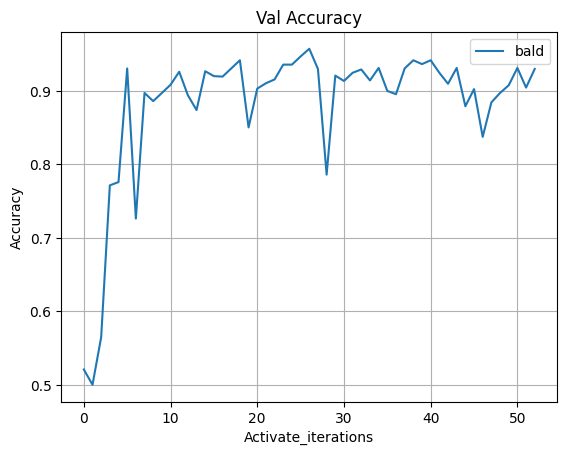

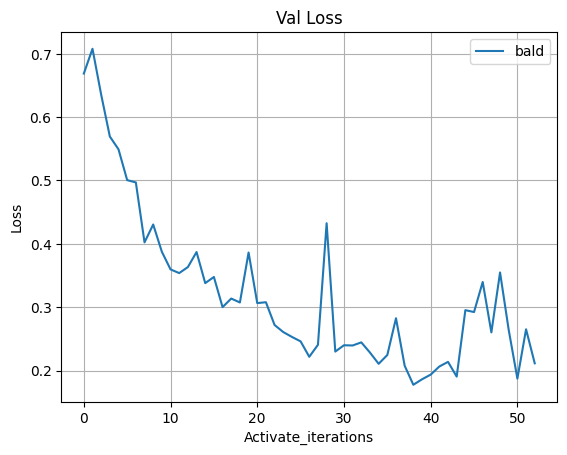

In [4]:
fig, ax = plt.subplots(1,1)
fig2, ax2 = plt.subplots(1,1)

for modeluse in hyperparams["model"]: #对每一种启发式方法查询策略进行主动学习，绘制性能曲线
    for query_strategy in hyperparams["heuristic"]:
        t_loss = []
        print("Start active learning Training: model is ", modeluse, '\n')
        print("Start active learning Training: query_strategy is ", query_strategy, '\n')
        best_acc = 0
        performance = [] #用于记录每个查询策略的性能
        active_set, test_set = get_datasets(hyperparams["initial_pool"])
        if(query_strategy != 'bald'):
            reduction = 'mean'
        else:
            reduction = 'none'
        print('reduction on main is ', reduction)
        heuristic = get_heuristic(query_strategy, hyperparams["shuffle_prop"], reduction = reduction) #启发式算法bald，并添加噪声
        criterion = CrossEntropyLoss()
        if modeluse == 'vgg16':
            model = vgg16(num_classes=2)
            weights_path = "/root/主动学习//vgg16-397923af.pth"
        elif modeluse == 'AlexNet':
            model = AlexNet(num_classes=2)
            weights_path = "/root/主动学习//alexnet-owt-4df8aa71.pth"
        weights = torch.load(weights_path, map_location='cpu')
        weights = {k: v for k, v in weights.items() if "classifier.6" not in k}
        model.load_state_dict(weights, strict=False)

        # change dropout layer to MCDropout
        model = patch_module(model)

        if use_cuda:
            model.cuda()
        optimizer = optim.SGD(model.parameters(), lr=hyperparams["lr"], momentum=0.9)

        # Wraps the model into a usable API.
        model = ModelWrapper(model, criterion, replicate_in_memory=False)

        logs = {}
        logs["epoch"] = 0

        # for prediction we use a smaller batchsize
        # since it is slower
        active_loop = ActiveLearningLoop(
            active_set,
            model.predict_on_dataset,
            heuristic,  # 给定启发式算法
            hyperparams.get("query_size", 1),  # 每次标记的样本数
            batch_size=10,
            iterations=hyperparams["iterations"],  # 从后验分布采样次数
            use_cuda=use_cuda,
        )
        # We will reset the weights at each active learning step.
        init_weights = deepcopy(model.state_dict()) #每次主动学习前初始化权重

        labelling_progress = active_set.labelled.copy().astype(int)#将active_set对象的labelled属性复制为一个整数类型的数组labelling_progress。
        with open("results.txt", "w") as file:
            for epoch in tqdm(range(hyperparams['epoch'])):  #主动学习循环次数
                # Load the initial weights.
                model.load_state_dict(init_weights)
                model.train_on_dataset(  #这个函数可以返回一次主动循环的训练日志
                    active_set,
                    optimizer,
                    hyperparams["batch_size"],
                    hyperparams["learning_epoch"],  #训练的epoch数
                    use_cuda,
                )

                # Validation!
    #             test_acc = model.test_on_dataset(test_set, hyperparams["batch_size"], use_cuda)
    #             performance.append(test_acc)

    #             should_continue = active_loop.step()    #执行主动学习步骤，根据启发式算法标记新样本
    #             # Keep track of progress
    #             labelling_progress += active_set._labelled.astype(np.uint16)#主动学习标记样本进度
    #             if not should_continue:
    #                 break

    #             model_weight = model.state_dict()
    #             dataset = active_set.state_dict()
    #             if test_acc > best_acc:
    #                 best_acc = test_acc
    #                 print("Save weights in "+query_strategy+str(_)+'al')
    #                 torch.save({'model': model_weight, 'dataset': dataset, 'labelling_progress': labelling_progress},
    #                        'best_{}.pth'.format([query_strategy]))
                result = model.test_on_dataset(test_set, hyperparams["batch_size"], use_cuda, average_predictions=10)
                Uth = result[0]
                test_acc = result[1]
                test_loss = result[2]
                # 写入当前 epoch 的结果
                file.write(f"query_strategy: {query_strategy}:\n")
                file.write(f"Epoch {epoch}:\n")
                file.write(f"dataset: {len(active_set)}:\n")
                file.write(f"Uth: {Uth}:\n")
                file.write(f"test_acc: {test_acc}:\n")
                file.write(f"test_loss: {test_loss}:\n")
                file.write("\n")  # 添加一个空行以分隔各个 epoch 的结果
                
                print('Uth-----------', Uth)
                performance.append(test_acc)
                t_loss.append(test_loss)
                should_continue = active_loop.step()    #执行主动学习步骤，根据启发式算法标记新样本
                # Keep track of progress
                labelling_progress += active_set._labelled.astype(np.uint16)#主动学习标记样本进度
                if not should_continue:
                    break

                model_weight = model.state_dict()
                dataset = active_set.state_dict()
                if test_acc > best_acc:
                    best_acc = test_acc
                    Uncertain_th = Uth.cpu().numpy() #更新不确定性阈值
                    print("!!!Save weights in "+modeluse+str(_)+'al')
                    print('Uncertain_th update to', Uncertain_th)
                    torch.save({'model': model_weight, 'dataset': dataset, 'labelling_progress': labelling_progress},
                           'best_{}.pth'.format([query_strategy]))
                    with open('model_params.txt', 'w') as f:
                        f.write("Uncertain-threshold:"+str(Uth)+'\n')
                pprint(model.get_metrics())
            # 绘制性能曲线
            # 绘制性能曲线
            ax.plot(range(hyperparams["epoch"]), performance, label=query_strategy)#绘制一条曲线 横坐标为主动学习循环次数，纵坐标为test_acc
            ax2.plot(range(hyperparams["epoch"]), t_loss, label=query_strategy)
            # Make a feature extractor from our trained model.
            class FeatureExtractor(nn.Module):
                def __init__(self, model):
                    super().__init__()
                    self.model = model

                def forward(self, x):
                    return torch.flatten(self.model.features(x), 1)

            def plot_images(img_list):
                def init():
                    img.set_data(img_list[0])
                    return (img,)

                def animate(i):
                    img.set_data(img_list[i])
                    return (img,)

                fig = plt.Figure(figsize=(10, 10))
                ax = fig.gca()
                img = ax.imshow(img_list[0])
                anim = animation.FuncAnimation(fig, animate, init_func=init,
                                               frames=len(img_list), interval=60, blit=True)
                return anim

            features = FeatureExtractor(model.model)
            acc = []
            for x, y in DataLoader(active_set._dataset, batch_size=10):
                acc.append((features(x.cuda()).detach().cpu().numpy(), y.detach().cpu().numpy()))

            xs, ys = zip(*acc)
            # Compute t-SNE on the extracted features.
            tsne = TSNE(n_jobs=1, learning_rate='auto')
            transformed = tsne.fit_transform(np.vstack(xs))
            labels = np.concatenate(ys)
            print(labels.shape)
            # Create frames to animate the process.
            frames = make_animation_from_data(transformed, labels, labelling_progress, ["Positive", "Negative"])
            gifpath = "/root/"+query_strategy+modeluse+'.gif'
            print('Start draw gif')
            imageio.mimsave(gifpath, frames, duration=333.33)
            print('Done gif')
print('Uncertain_th:', Uncertain_th)
# 添加图例
ax.legend()
ax2.legend()
# 添加横轴标签和纵轴标签
ax.set_xlabel('Activate_iterations')
ax.set_ylabel('Accuracy')
ax2.set_xlabel('Activate_iterations')
ax2.set_ylabel('Loss')
# 设置标题、坐标轴范围等其他设置
ax.set_title('Val Accuracy')
ax2.set_title('Val Loss')
ax.grid(True)
ax2.grid(True)
# 显示图形
plt.show()